In [ ]:
# pip install fiftyone 

In [ ]:
import fiftyone as fo
import fiftyone.utils.huggingface as fouh

# Load the dataset from Hugging Face if it's your first time using it

# dataset = fouh.load_from_hub(
#     "Voxel51/Coursera_lecture_dataset_train", 
#     dataset_name="lecture_dataset_train", 
#     persistent=True
#     )

In [ ]:
dataset = fo.load_dataset("lecture_dataset_train_clone")

# Detecting Occlusions


1. `detect_image_occlusion` function:
   This function is the main driver for occlusion detection. It processes each ground truth detection in a given image sample. For each detection:
   - It extracts a region of interest (ROI) around the bounding box, adding a 20% padding to capture potential occlusions just outside the box.
   - It applies Gaussian blur to reduce noise, which helps in more accurate edge detection.
   - Canny edge detection is used to identify edges in the ROI.
   - Hough Line Transform is applied to detect straight lines from the edges.
   - For each detected line, it checks if the line intersects or is close to the original (unpadded) bounding box using the `line_box_intersection` function.
   - If any line is found to intersect or be close to the box, it's considered a potential occlusion.

   The function includes several safety checks, such as ensuring the image can be loaded and the ROI is valid, to handle potential edge cases in the dataset.

2. `line_box_intersection` function:
   This function determines whether a given line segment potentially represents an occlusion for a bounding box. It uses two methods:
   - Line Intersection: It checks if the line segment intersects any of the edges of the bounding box. This is done efficiently using the concept of counterclockwise (CCW) orientation of points.
   - Proximity Check: If the line doesn't intersect the box, it checks if any part of the line is within a small threshold distance (5 pixels) from the box. This catches cases where an occluding object might be very close to but not quite touching the bounding box.

   The CCW check is a clever way to determine if two line segments intersect without actually calculating the intersection point, making it computationally efficient.

These functions work together to provide a heuristic approach to detecting potential occlusions. While not perfect (it may have false positives or miss some occlusions), it provides a computationally efficient way to flag images that might have occlusion issues for further review or processing.

In [ ]:
import fiftyone as fo
import cv2
import numpy as np

def detect_image_occlusion(sample):
    """
    Detect potential occlusions in bounding boxes of an image sample.

    This function analyzes the areas within and around ground truth bounding boxes
    for edge patterns that might indicate occlusions. It processes each detection
    in the sample, applying image processing techniques to identify line patterns
    that could represent occluding objects.

    The function performs the following steps for each detection:
    1. Extracts and pads the region of interest (ROI) around the bounding box.
    2. Applies Gaussian blur to reduce noise in the ROI.
    3. Uses Canny edge detection to identify edges in the ROI.
    4. Applies Hough Line Transform to detect lines from the edges.
    5. Checks if any detected lines intersect or are close to the original bounding box.

    Note:
        This function assumes that the sample has a 'ground_truth' field with 'detections'.
        It also assumes that the bounding box coordinates in the detections are normalized.
    """
    # Load the image from the sample's filepath
    image = cv2.imread(sample.filepath)
    if image is None:
        print(f"Warning: Could not read image from {sample.filepath}")
        return False

    height, width = image.shape[:2]

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Get ground truth detections from the sample
    detections = sample.ground_truth.detections

    for detection in detections:
        # Extract bounding box coordinates and convert to absolute pixel coordinates
        rel_x, rel_y, rel_w, rel_h = detection.bounding_box
        x1 = int(rel_x * width)
        y1 = int(rel_y * height)
        x2 = int((rel_x + rel_w) * width)
        y2 = int((rel_y + rel_h) * height)
        
        # Add padding around the detection (e.g., 20% of the detection size)
        pad_x = int(0.2 * (x2 - x1))
        pad_y = int(0.2 * (y2 - y1))
        
        # Ensure padded coordinates are within image bounds
        x1_pad = max(0, x1 - pad_x)
        y1_pad = max(0, y1 - pad_y)
        x2_pad = min(width, x2 + pad_x)
        y2_pad = min(height, y2 + pad_y)
        
        # Check if the ROI is valid
        if x1_pad >= x2_pad or y1_pad >= y2_pad:
            print(f"Warning: Invalid ROI for detection in sample {sample.id}")
            continue

        # Extract the region of interest (ROI)
        roi = gray[y1_pad:y2_pad, x1_pad:x2_pad]
        
        # Check if ROI is empty
        if roi.size == 0:
            print(f"Warning: Empty ROI for detection in sample {sample.id}")
            continue

        # Apply Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(roi, (5, 5), 0)
        
        # Apply Canny edge detection on the ROI
        edges = cv2.Canny(blurred, 50, 150, apertureSize=3)
        
        # Apply Hough Transform to detect lines in the ROI
        lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=30, minLineLength=20, maxLineGap=5)
        
        if lines is not None:
            for line in lines:
                x1_line, y1_line, x2_line, y2_line = line[0]
                
                # Adjust line coordinates to image coordinates
                x1_line += x1_pad
                x2_line += x1_pad
                y1_line += y1_pad
                y2_line += y1_pad
                
                # Check if the line intersects or is close to the original (unpadded) bounding box
                if line_box_intersection(x1_line, y1_line, x2_line, y2_line, x1, y1, x2, y2):
                    return True  # Potential occlusion detected

    return False  # No potential occlusion detected

def line_box_intersection(x1, y1, x2, y2, box_x1, box_y1, box_x2, box_y2):
    """
    Check if a line intersects or is close to a bounding box.

    This function uses two methods to determine if a line segment potentially
    represents an occlusion for a given bounding box:

    1. Line Intersection: It checks if the line segment intersects any of the
       edges of the bounding box using the concept of counterclockwise orientation.

    2. Proximity Check: If the line doesn't intersect, it checks if any part of
       the line is within a small threshold distance (5 pixels) from the box.

    Args:
        x1, y1 (int): Coordinates of the start point of the line segment.
        x2, y2 (int): Coordinates of the end point of the line segment.
        box_x1, box_y1 (int): Coordinates of the top-left corner of the bounding box.
        box_x2, box_y2 (int): Coordinates of the bottom-right corner of the bounding box.

    Returns:
        bool: True if the line intersects or is close to the box, False otherwise.

    Note:
        The function uses a counterclockwise (CCW) orientation check to determine
        line intersection efficiently.
    """
    def ccw(A, B, C):
        """
        Determine if three points are listed in counterclockwise order.

        Returns:
            bool: True if points A, B, C are in counterclockwise order, False otherwise.
        """
        return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

    # Check if line intersects any of the bounding box edges
    if ccw((x1,y1),(box_x1,box_y1),(box_x2,box_y1)) != ccw((x2,y2),(box_x1,box_y1),(box_x2,box_y1)) and \
       ccw((x1,y1),(box_x2,box_y1),(box_x2,box_y2)) != ccw((x2,y2),(box_x2,box_y1),(box_x2,box_y2)):
        return True

    # Check if line is close to the bounding box (within 5 pixels)
    threshold = 5
    if (min(x1, x2) <= box_x2 + threshold and max(x1, x2) >= box_x1 - threshold and
        min(y1, y2) <= box_y2 + threshold and max(y1, y2) >= box_y1 - threshold):
        return True

    return False
# Process each sample in the dataset
for sample in dataset:
    # Detect if there's a potential occlusion in the image
    has_occlusion = detect_image_occlusion(sample)
    
    # Add the occlusion flag to the sample
    sample['has_occlusion'] = has_occlusion

    sample.save()


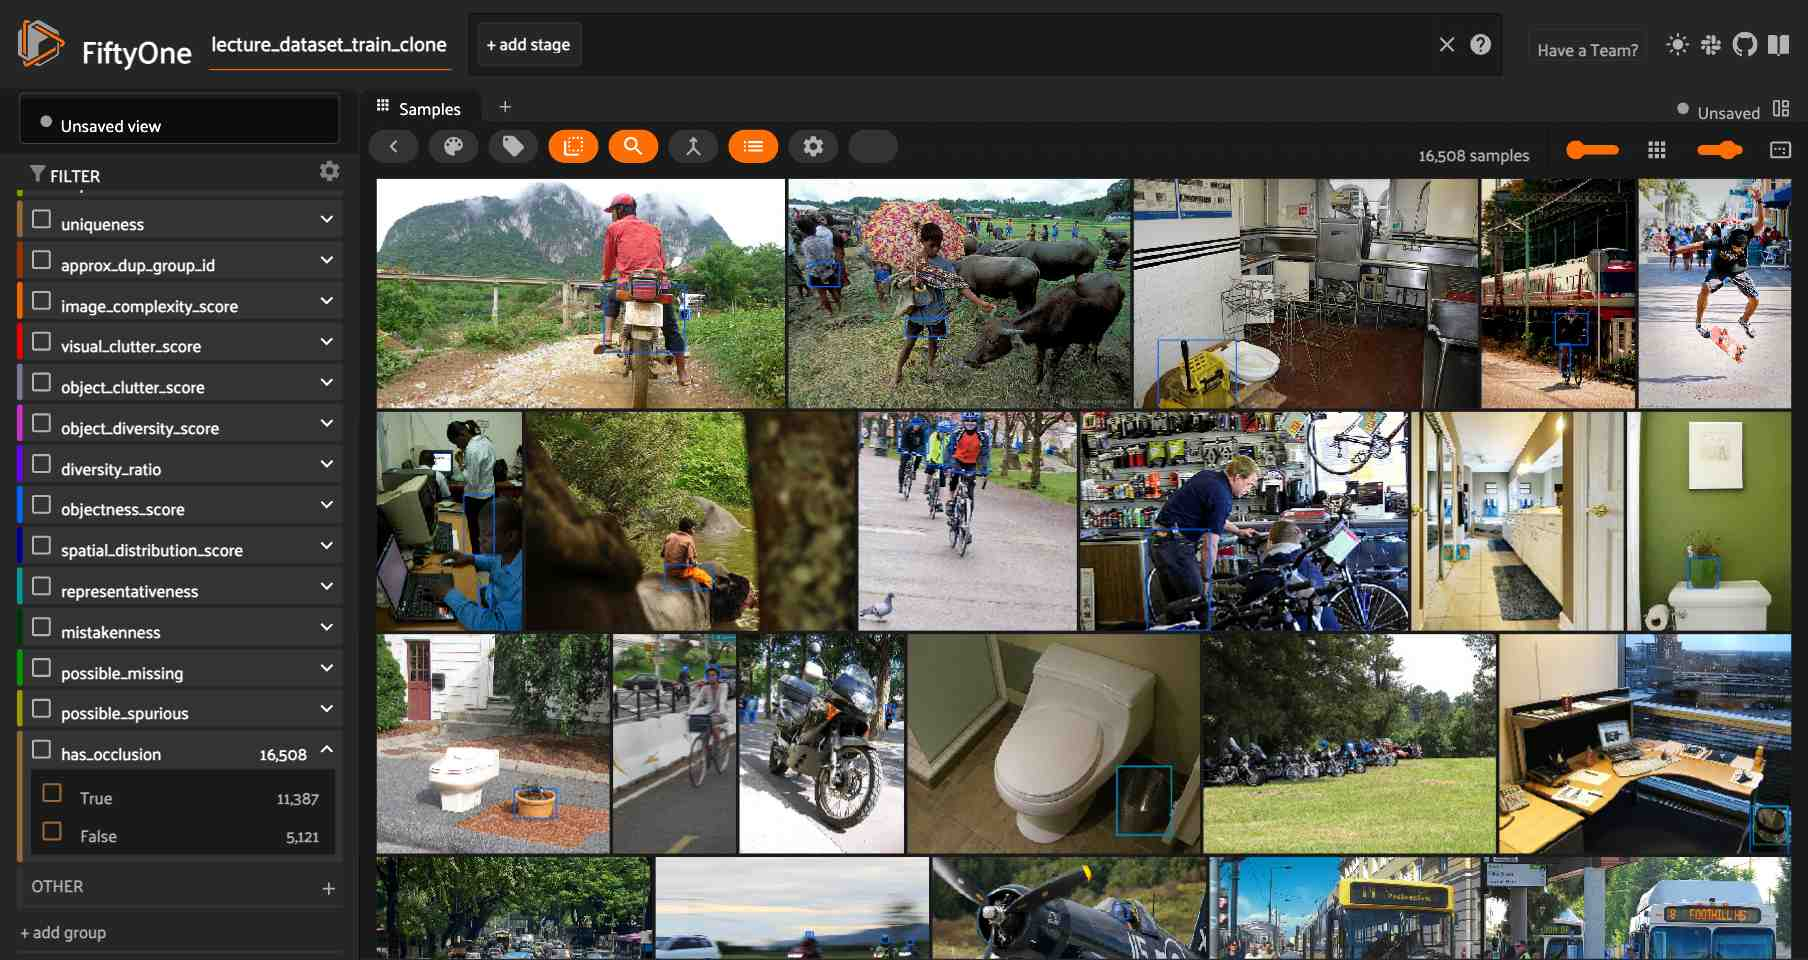

Dataset:          lecture_dataset_train_clone
Media type:       image
Num samples:      16508
Selected samples: 0
Selected labels:  0
Session URL:      http://localhost:5151/

In [8]:
fo.launch_app(dataset)

# Data augmentation techniques for occlusion

The primary goal of occlusion-based data augmentation is to create models that can generalize better to real-world scenarios. In reality, objects are often partially hidden or viewed from different angles, and our models need to be prepared for these situations.

This is particularly beneficial when:

1. Training models to recognize objects that may be partially obscured in real-world scenarios.

2. Dealing with limited training data.

3. Addressing signs of overfitting to specific features in the training set.

Several effective techniques can be used to simulate occlusions and improve model performance:

1. **Random erase**: These methods involve randomly removing or masking sections of the input image during training.

2. **CutMix**: This technique replaces a section of one image with a section from another, encouraging the model to learn from partial information and diverse contexts.

3. **Mosaic**: This method stitches together four images, forcing the model to identify objects in various contexts and positions within a single training sample.

4. **MixUp**: While not strictly an occlusion technique, MixUp combines multiple images at the pixel level, which can help the model learn patterns related to partially visible objects.

By applying these techniques, we challenge our models to learn more robust and generalizable features, ultimately improving their performance in real-world scenarios where occlusions are common.

### Ultralytics handles these augmentations for during training


| Technique | Type | Default Value | Range | Description |
|-----------|------|---------------|-------|-------------|
| mixup | float | 0.0 | 0.0 - 1.0 | Blends two images and their labels, creating a composite image. Enhances the model's ability to generalize by introducing label noise and visual variability. |
| mosaic | float | 1.0 | 0.0 - 1.0 | Combines four training images into one, simulating different scene compositions and object interactions. Highly effective for complex scene understanding. |
| erasing | float | 0.4 | 0.0 - 0.9 | Randomly erases a portion of the image during classification training, encouraging the model to focus on less obvious features for recognition. |
| copy_paste | float | 0.0 | 0.0 - 1.0 | Copies objects from one image and pastes them onto another, useful for increasing object instances and learning object occlusion. |


You can adjust the values for these in the training_config.yaml, or pass your chosen values directly to the `train` method.

# Computing pairwise IoUs between objects

You could do this using FiftyOne’s `compute_ious` function which computes the pairwise IoUs between objects. 

In [ ]:
import fiftyone.utils.iou as foui
from fiftyone import ViewField as F

def get_overlapping_classes_view(dataset, class1, class2):
    """
    Get a view of samples where bounding boxes of two specified classes overlap.

    Args:
        dataset (fiftyone.core.dataset.Dataset): The FiftyOne dataset to process.
        class1 (str): The name of the first class.
        class2 (str): The name of the second class.

    Returns:
        fiftyone.core.view.DatasetView: A view of the dataset containing only the samples
        where bounding boxes of class1 and class2 overlap.
    """
    # Get detections for each class
    class1_detections = dataset.filter_labels("ground_truth", F("label") == class1, only_matches=False).values("ground_truth.detections")
    class2_detections = dataset.filter_labels("ground_truth", F("label") == class2, only_matches=False).values("ground_truth.detections")

    # Get sample IDs
    sample_ids = dataset.values("id")

    # Find samples with overlapping detections
    overlapping_ids = []
    for sample_id, class1_dets, class2_dets in zip(sample_ids, class1_detections, class2_detections):
        if class1_dets and class2_dets:
            if foui.compute_ious(class1_dets, class2_dets).any():
                # There exists at least one overlapping class1 and class2 detection in this sample
                overlapping_ids.append(sample_id)

    # Create and return the view
    overlapping_view = dataset.select(overlapping_ids)
    return overlapping_view

overlapping_onion_and_tomato = get_overlapping_classes_view(dataset, "onion", "tomato")


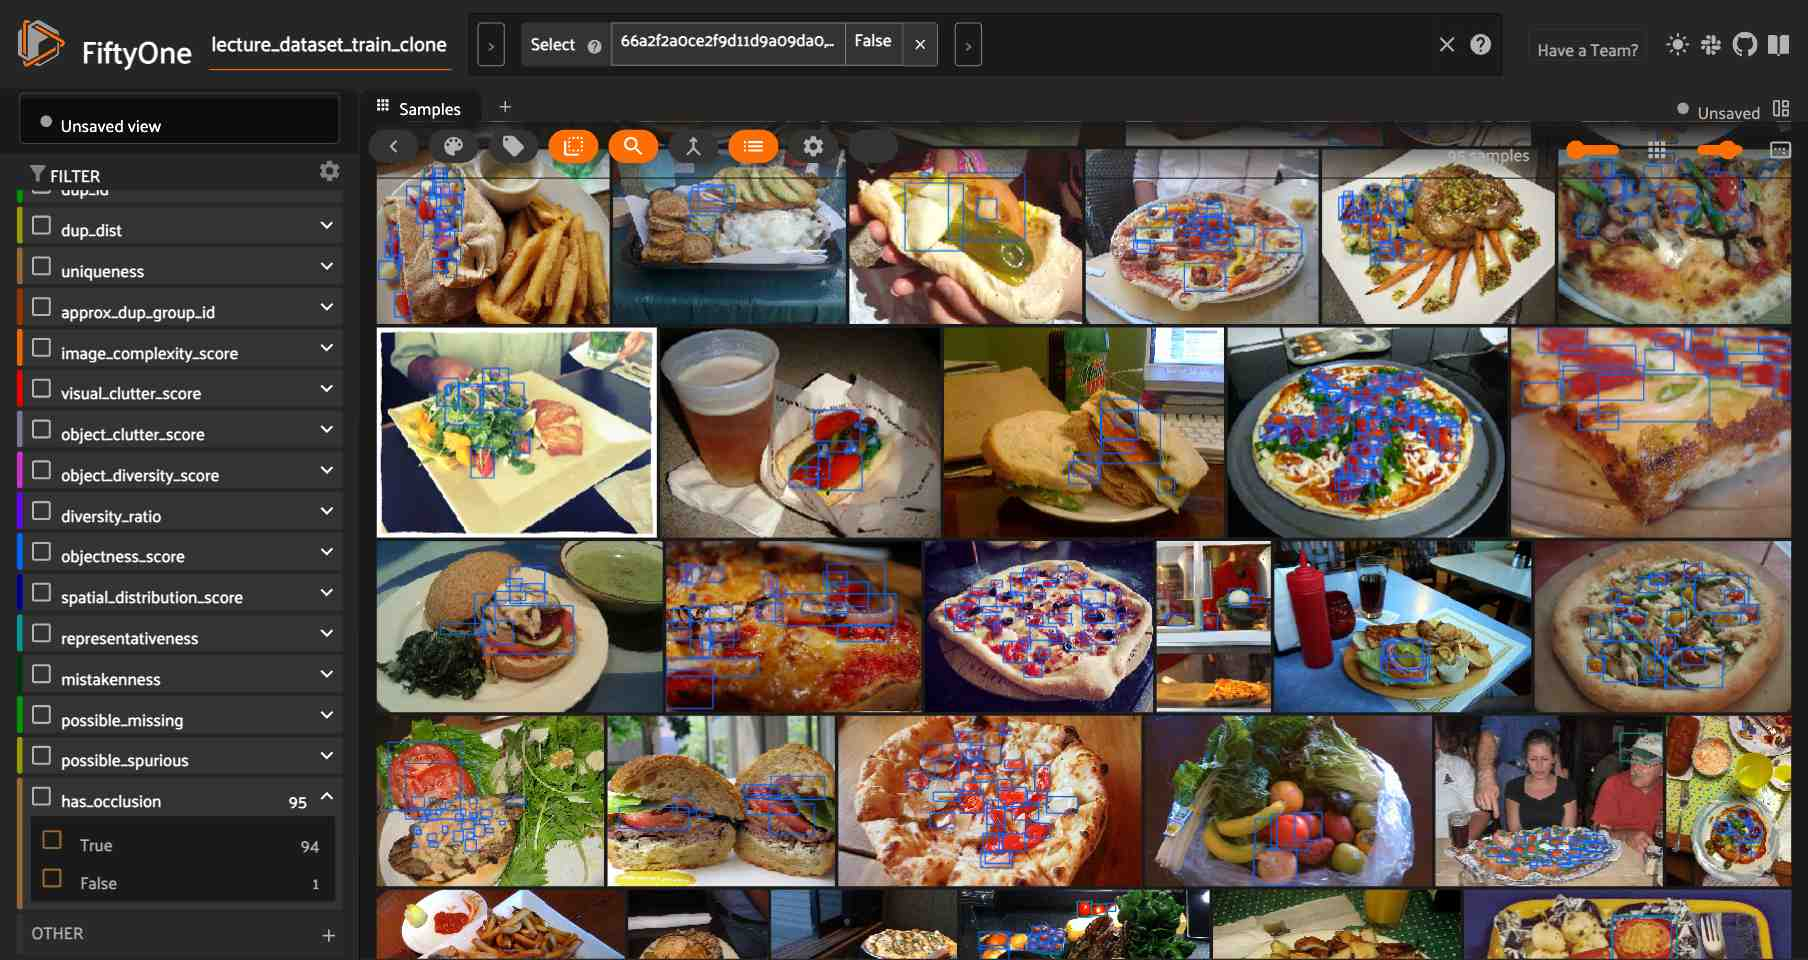

Dataset:          lecture_dataset_train_clone
Media type:       image
Num samples:      95
Selected samples: 0
Selected labels:  0
Session URL:      http://localhost:5151/
View stages:
    1. Select(sample_ids=['66a2f2a0ce2f9d11d9a09da0', '66a2f2a1ce2f9d11d9a0a060', '66a2f2a2ce2f9d11d9a0a1a8', ...], ordered=False)

In [9]:
fo.launch_app(overlapping_onion_and_tomato)

### Identify images with overlapping bounding boxes or boxes that are very close to each other.

Even without predictions, [`compute_max_ious`](https://docs.voxel51.com/api/fiftyone.utils.iou.html#fiftyone.utils.iou.compute_max_ious) can be a powerful tool for exploring and understanding your dataset. Using `compute_max_ious` in this exploratory way, you're gaining valuable insights into the spatial characteristics of your dataset. This understanding is crucial for making informed decisions about data preprocessing, model selection, and potential challenges in the machine learning pipeline, even before you start training models or generating predictions. 

It's a data-centric approach to understanding the fundamental properties of your visual data. Here's how you can use it to gain insights into your data:

1. Object Analysis:
   - By computing IoUs between objects in the same field (e.g., ground truth), you can understand how much objects in your dataset tend to overlap.
   - High overlap between objects can indicate complex scenes, which might be challenging for models to learn.
   - Low overlap might suggest simpler scenes or more isolated objects.
   - This can reveal patterns in object placement, density, or size in your images
        - Very low IoUs might indicate many small objects, while higher IoUs could suggest larger or more prominent objects.
   - Samples with extreme IoU values (very high or very low) might represent edge cases in your dataset that deserve special attention.

2. Annotation Consistency Check:
   - If you have multiple annotations for the same images (e.g., from different annotators), you can compare them using IoU.
   - This helps identify discrepancies in annotation styles or potential errors.
   - Extremely high IoUs between different objects might indicate duplicate or erroneously split annotations that need correction.   

3. Potential Occlusion Detection:
   - High IoUs between different object classes might indicate frequent occlusions in your dataset.
   - Analyzing IoU distributions across different object classes can reveal if certain classes tend to appear in more crowded or isolated contexts.

In [ ]:
import fiftyone.utils.iou as foui
from fiftyone import ViewField as F

# Compute the maximum IoU for each object in the "ground_truth" field
foui.compute_max_ious(dataset, "ground_truth", iou_attr="max_iou", classwise=False)

# Filter labels objects with IoU greater than 0.75, 
view_with_high_ious = dataset.filter_labels("ground_truth", F("max_iou") > 0.75)

In [10]:
for label in dataset.distinct("ground_truth.detections.label"):
    view = dataset.filter_labels("ground_truth", F("label") == label)
    quantiles = view.quantiles("ground_truth.detections.max_iou", quantiles=[0.25, 0.5, 0.75, 0.95])
    print(f"The quantiles of max_iou for {label} are: {quantiles}")

The quantiles of max_iou for baseball_cap are: [0.0, 0.0, 0.0, 0.28169809184840333]
The quantiles of max_iou for bucket are: [0.0, 0.0, 0.048725265715742566, 0.47403586630375594]
The quantiles of max_iou for coat are: [0.0, 0.03677815455518386, 0.1267284133437442, 0.9123840256869961]
The quantiles of max_iou for doughnut are: [0.061871915203247474, 0.13188839736234106, 0.3005870166957054, 0.9658876577207536]
The quantiles of max_iou for flowerpot are: [0.0, 0.0, 0.01899063957369378, 0.14952724004677523]
The quantiles of max_iou for goggles are: [0.0, 0.0, 0.1470182944570415, 0.6006982344811053]
The quantiles of max_iou for hat are: [0.0, 0.0, 0.0, 0.511271162900548]
The quantiles of max_iou for helmet are: [0.0, 0.0, 0.0384924658151214, 0.473578914310306]
The quantiles of max_iou for jacket are: [0.0, 0.02716648960388547, 0.10685946029490148, 0.4428117582129471]
The quantiles of max_iou for jean are: [0.0, 0.0, 0.03474564848507017, 0.27047909484067306]
The quantiles of max_iou for onio

In [11]:
fo.launch_app(view_with_high_ious)

Dataset:          lecture_dataset_train_clone
Media type:       image
Num samples:      319
Selected samples: 0
Selected labels:  0
Session URL:      http://localhost:5151/
View stages:
    1. FilterLabels(field='ground_truth', filter={'$gt': ['$$this.max_iou', 0.75]}, only_matches=True, trajectories=False)

Learn more:


- Docs: [`compute_ious`](https://docs.voxel51.com/api/fiftyone.utils.iou.html#fiftyone.utils.iou.compute_ious)

 - Docs: [`compute_max_ious`](https://docs.voxel51.com/api/fiftyone.utils.iou.html#fiftyone.utils.iou.compute_max_ious)


- Colab notebook: [Augmenting datasets with Albumentations](https://colab.research.google.com/github/voxel51/fiftyone/blob/v0.25.0/docs/source/tutorials/data_augmentation.ipynb)


If you ever need assistance, have more complex questions, or want to keep in touch, feel free to join the Voxel51 community Discord server [here](https://discord.gg/QAyfnUhfpw)